In [2]:
#FASTSLAMはParticle Filterをベースとしたアルゴリズムで
#各パーティクルがロボットの位置と姿勢を表しており、
#各パーティクルごとに地図を確率的に推定し地図を所持しているのが特徴である．

import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [7]:
#ランドマークの推定位置を描写
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None #変更
        
    #推定結果を描写    
    def draw(self, ax, elems): 
        if self.cov is None:
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

In [4]:
#各パーティクルが持つ情報を設定

class MapParticle(Particle):  
    #各パーティクルの位置姿勢
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
            
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
     #ランドマークの位置推定を行う際、一つ前の情報を必要とするため
　　 #ランドマークを観測したとき、ランドマークの位置推定のガウス分布を初期化
        x, y, t = self.pose#姿勢
        ell, phi = z
        
        #ガウス分布の中心を算出
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y
    
    　　#ガウス分布を用いるために線形化している
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        #求めたHとQを使用してランドマークの位置推定の更新
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        landmark.pos = np.array([mx, my]).T
        
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
       #2度目以降に観測するランドマークの重みの更新と位置推定
    
    　　x, y, _ = self.pose
        mx, my =  landmark.pos
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
        estm_ell, _ = estm_z
        if estm_ell < 0.01:
            return
        
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        #　Kはカルマンゲイン
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        # 各パーティクルの重みはそのときの観測値から尤度関数に則って更新する
             
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        #現在位置と１つ前の位置とカルマンゲインから推定位置を更新
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev): 
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            #もしランドマークが初観測であればinit_landmark_estimatiを呼び出す
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [5]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        #Fastslam用のパーティクルの作成
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        
        # 尤度の高いパーティクルを先頭に配置
        self.ml = self.particles[0]
        
        #各パーティクルの観測
    def observation_update(self, observation):  
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        self.set_ml()　
        self.resampling() #リサンプリング
        
        #最も重みが大きい
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

<IPython.core.display.Javascript object>


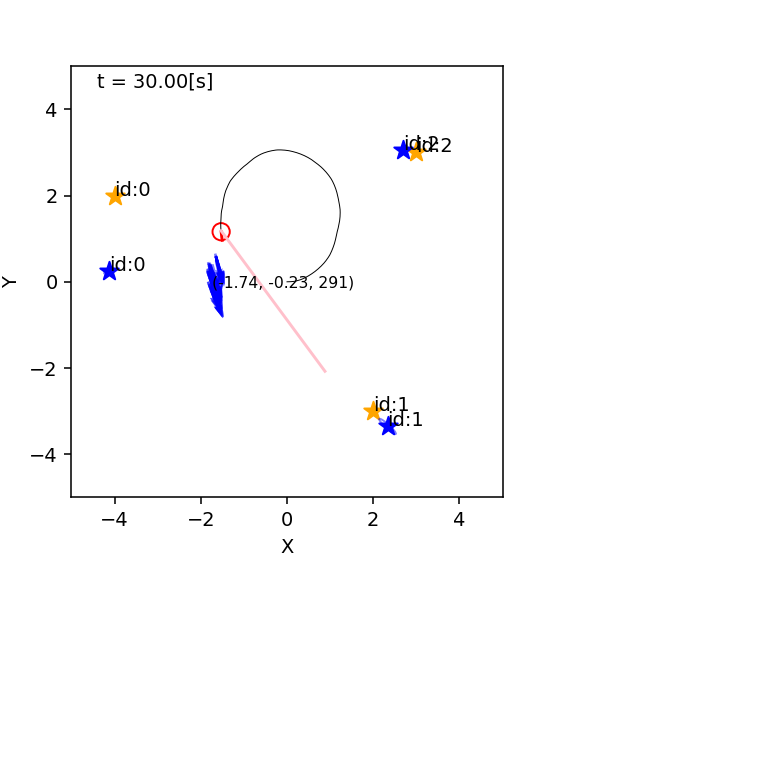

In [6]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    #地図、ランドマークの描写
    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略
    
    #エージェントロボットの描写
    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(100, init_pose, len(m.landmarks))
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [ ]:
a.estimator.particles[10].map.landmarks[2].cov

In [ ]:
math.sqrt(0.0025)